# Creating a Two Step Model

- The first model will help decide whether the driver will be active/ online on a particular day or not
- The second model will further score the number of hours the driver will be online in case the first model says that the driver will be active

# 1. Classification Model

***
-Binary Classification Model for deciding whether the driver will be active on a particular day or not
***

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score 
from sklearn.model_selection import learning_curve, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
import graphviz 
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [173]:
train = pd.read_parquet('train_data.parquet', engine='fastparquet')
test = pd.read_parquet('test_data.parquet', engine='fastparquet')

train['Ind'] = 'Train'
test['Ind'] = 'Test'
train["online_hours"] = train["online_hours"].astype(int)

In [177]:
kid_weekday = (train.groupby(['number_of_kids', 'weekday'])[['online_hours']].apply(lambda x: x.mean())).reset_index()
kid_weekday.columns = ['number_of_kids', 'weekday', 'Avg_kid_weekday_online_hours']
kid_age = (train.groupby(['number_of_kids', 'age_bucket'])[['online_hours']].apply(lambda x: x.mean())).reset_index()
kid_age.columns = ['number_of_kids', 'age_bucket', 'Avg_kid_age_online_hours']
age_weekday = (train.groupby(['weekday', 'age_bucket'])[['online_hours']].apply(lambda x: x.mean())).reset_index()
age_weekday.columns = ['weekday', 'age_bucket', 'Avg_weekday_age_online_hours']

In [178]:
kid_weekday.head()

,number_of_kids,weekday,Avg_kid_weekday_online_hours
0,0,0,5.789362
1,0,1,6.131762
2,0,2,6.136597
3,0,3,5.656089
4,0,4,6.258688


In [180]:
train = pd.merge(train, kid_weekday, on = ['number_of_kids', 'weekday'], how = 'left')
train = pd.merge(train, kid_age, on = ['number_of_kids', 'age_bucket'], how = 'left')
train = pd.merge(train, age_weekday, on = ['weekday', 'age_bucket'], how = 'left')

test = pd.merge(test, kid_weekday, on = ['number_of_kids', 'weekday'], how = 'left')
test = pd.merge(test, kid_age, on = ['number_of_kids', 'age_bucket'], how = 'left')
test = pd.merge(test, age_weekday, on = ['weekday', 'age_bucket'], how = 'left')

In [182]:
df =  pd.concat(objs=[train, test], axis=0, sort=True).reset_index(drop=True)
### Joining Train and Test data set for Processing together
df.head()
df.tail()

,Avg_kid_age_online_hours,Avg_kid_weekday_online_hours,Avg_weekday_age_online_hours,Ind,age,age_bucket,date,driver_id,gender,number_of_kids,online_hours,weekday,weekend_flag
0,6.155402,6.342803,5.651890,Train,49,2,2017-06-01,111556,FEMALE,4,2,3,0
1,6.155402,7.010417,6.301718,Train,49,2,2017-06-02,111556,FEMALE,4,2,4,0
2,6.155402,4.850379,4.350859,Train,49,2,2017-06-03,111556,FEMALE,4,0,5,1
3,6.155402,5.326705,4.501031,Train,49,2,2017-06-04,111556,FEMALE,4,0,6,1
4,6.155402,6.623106,5.990378,Train,49,2,2017-06-05,111556,FEMALE,4,5,0,0


,Avg_kid_age_online_hours,Avg_kid_weekday_online_hours,Avg_weekday_age_online_hours,Ind,age,age_bucket,date,driver_id,gender,number_of_kids,online_hours,weekday,weekend_flag
69575,5.630855,4.485947,4.810579,Test,27,1,2017-06-24,998740,MALE,0,0,5,1
69576,5.630855,4.500151,4.922872,Test,27,1,2017-06-25,998740,MALE,0,0,6,1
69577,5.630855,5.789362,6.129433,Test,27,1,2017-06-26,998740,MALE,0,0,0,0
69578,5.630855,6.131762,6.471631,Test,27,1,2017-06-27,998740,MALE,0,0,1,0
69579,5.630855,6.136597,6.606087,Test,27,1,2017-06-28,998740,MALE,0,0,2,0


### Creating the Binary Indicator for Online

In [183]:
df['online'] = 0
df.loc[df['online_hours'] > 0, 'online'] = 1

### Convert categorical variables into pandas category

In [184]:
df.gender = df.gender.astype('category')
df.gender.cat.set_categories(['MALE', 'FEMALE'], ordered=True, inplace=True)

df.gender = df.gender.cat.codes

In [186]:
df.head()

,Avg_kid_age_online_hours,Avg_kid_weekday_online_hours,Avg_weekday_age_online_hours,Ind,age,age_bucket,date,driver_id,gender,number_of_kids,online_hours,weekday,weekend_flag,online
0,6.155402,6.342803,5.651890,Train,49,2,2017-06-01,111556,1,4,2,3,0,1
1,6.155402,7.010417,6.301718,Train,49,2,2017-06-02,111556,1,4,2,4,0,1
2,6.155402,4.850379,4.350859,Train,49,2,2017-06-03,111556,1,4,0,5,1,0
3,6.155402,5.326705,4.501031,Train,49,2,2017-06-04,111556,1,4,0,6,1,0
4,6.155402,6.623106,5.990378,Train,49,2,2017-06-05,111556,1,4,5,0,0,1


In [187]:
#Drop name & age columns
df.drop(['date','online_hours', 'driver_id'], axis=1, inplace=True)
df.head()

,Avg_kid_age_online_hours,Avg_kid_weekday_online_hours,Avg_weekday_age_online_hours,Ind,age,age_bucket,gender,number_of_kids,weekday,weekend_flag,online
0,6.155402,6.342803,5.651890,Train,49,2,1,4,3,0,1
1,6.155402,7.010417,6.301718,Train,49,2,1,4,4,0,1
2,6.155402,4.850379,4.350859,Train,49,2,1,4,5,1,0
3,6.155402,5.326705,4.501031,Train,49,2,1,4,6,1,0
4,6.155402,6.623106,5.990378,Train,49,2,1,4,0,0,1


### Separate train dataset and test dataset

In [188]:
train = df[df['Ind'] == 'Train']
test = df[df['Ind'] == 'Test']
#test.drop(["online"],axis = 1,inplace=True)
train.shape
test.shape

(52080, 11)

(17500, 11)

In [189]:
# Separate train features and label 
train["online"] = train["online"].astype(int)
y = train["online"]
df = train.drop(["online", 'Ind'],axis = 1)
df.head()

/home/jovyan/.conda/envs/pycp_py3k/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Avg_kid_age_online_hours,Avg_kid_weekday_online_hours,Avg_weekday_age_online_hours,age,age_bucket,gender,number_of_kids,weekday,weekend_flag
0,6.155402,6.342803,5.651890,49,2,1,4,3,0
1,6.155402,7.010417,6.301718,49,2,1,4,4,0
2,6.155402,4.850379,4.350859,49,2,1,4,5,1
3,6.155402,5.326705,4.501031,49,2,1,4,6,1
4,6.155402,6.623106,5.990378,49,2,1,4,0,0


## Random Forest Model for Classification

In [190]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df, y, test_size=0.2)

print('Training set: %s, %s' %(X_train.shape, y_train.shape))
print('Validation set: %s, %s' %(X_val.shape, y_val.shape))

m = RandomForestClassifier(n_estimators = 500, min_samples_leaf = 5, max_depth=3, n_jobs = -1, oob_score=True)
m.fit(X_train, y_train)

Training set: (41664, 9), (41664,)
Validation set: (10416, 9), (10416,)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [191]:
m.score(X_train, y_train)

m.score(X_val, y_val)

0.8320612519201229

0.8339093701996928

In [192]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

rf_feat_importance(m, X_train)

,cols,imp
7,weekday,0.257573
2,Avg_weekday_age_online_hours,0.246094
1,Avg_kid_weekday_online_hours,0.214617
8,weekend_flag,0.210033
5,gender,0.064050
3,age,0.004089
4,age_bucket,0.001887
0,Avg_kid_age_online_hours,0.001385
6,number_of_kids,0.000272


### Scoring the Test Population

In [195]:
y_test = test['online']
test.drop([ 'Ind','online'], axis=1, inplace=True)

In [196]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

dict_characters = {0: 'Not Online', 1: 'Online'}

Accuracy of Random Forest Classifier on training data: 0.83
Accuracy of Random Forest Classifier on testing data: 0.82


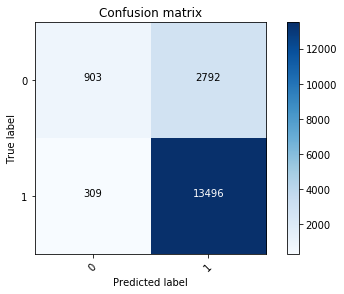

In [197]:
print('Accuracy of Random Forest Classifier on training data: {:.2f}'.format(m.score(X_train,y_train)))
print('Accuracy of Random Forest Classifier on testing data: {:.2f}'.format(m.score(test,y_test)))
model = m
prediction = model.predict(test)
cnf_matrix = confusion_matrix(y_test, prediction)
plt.show()

plot_confusion_matrix(cnf_matrix, classes=dict_characters,title='Confusion matrix')
plt.show()

Text(0.5,1,'Precision-Recall vs Threshold Chart')

Text(0,0.5,'Precision, Recall')

Text(0.5,0,'Threshold')

(0, 1)

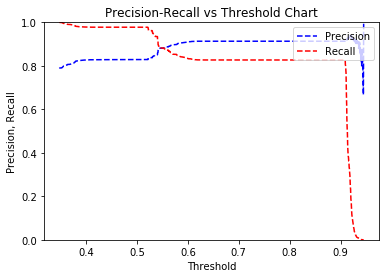

In [198]:
probs_y=m.predict_proba(test)
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:,1]) 
   #retrieve probability of being 1(in second column of probs_y)


pr_auc = auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper right")
plt.ylim([0,1])

# 2. Regression Model

***
-Regression Model to score the ones which have been classified as Online/ Active days for Drivers
***

In [ ]:
train = pd.read_parquet('train_data.parquet', engine='fastparquet')
test = pd.read_parquet('test_data.parquet', engine='fastparquet')

train['Ind'] = 'Train'
test['Ind'] = 'Test'
train["online_hours"] = train["online_hours"].astype(int)